In [42]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import roc_curve, auc
import zipfile
from torch.utils.data import random_split


In [2]:
data_dir='/kaggle/input/skin-cancer-isic-images'

In [3]:
print(os.listdir(data_dir))
len(os.listdir(data_dir))

['benign', 'malignant']


2

In [4]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
transform=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
])
dataset = ImageFolder(data_dir,transform=transform)

In [5]:
len(dataset.classes)

2

In [6]:
img ,label=dataset[124]
print(img.shape)

torch.Size([3, 224, 224])


In [7]:
torch.max(img)

tensor(0.9333)

Class: benign , Label: 0


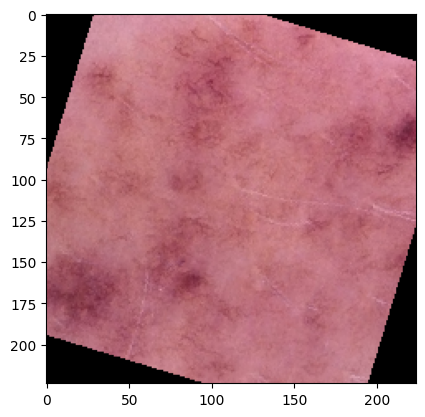

In [8]:
import matplotlib.pyplot as plt
print('Class:',dataset.classes[label],',','Label:',label)
plt.imshow(img.permute(1,2,0))

In [9]:
train_size=int(0.8*len(dataset))
val_size=int(0.1*len(dataset))
test_size= len(dataset)-train_size-val_size

train_data,val_data,test_data=random_split(dataset,[train_size,val_size,test_size])
print(len(train_data),len(val_data),len(test_data))

2637 329 331


In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size=64
train_dl=DataLoader(train_data,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl=DataLoader(val_data,batch_size*2,shuffle=True,num_workers=2,pin_memory=True)

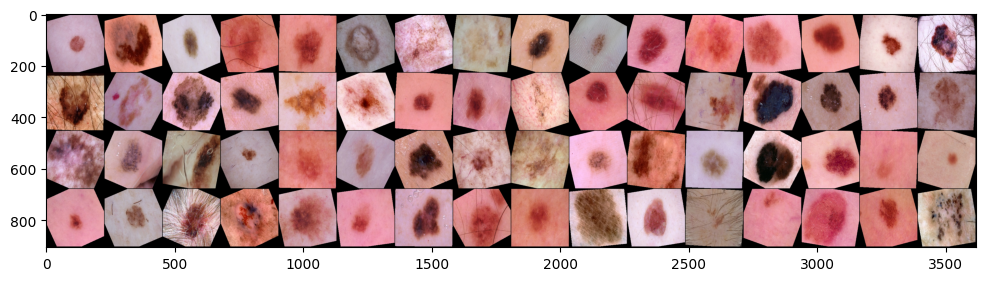

In [11]:
from torchvision.utils import make_grid
for images,labels in train_dl:
  fig,ax = plt.subplots(figsize=(12,6))
  ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
  break

In [12]:
class ClassifierBase(nn.Module):
  def training_step(self, batch):
      images,labels = batch
      out=self(images)
      loss=F.cross_entropy(out,labels)
      return loss

  def validation_step(self,batch):
      images, labels = batch
      out=self(images)
      loss=F.cross_entropy(out,labels)
      acc=accuracy(out,labels)
      return {'val_loss':loss.detach(),'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_losses=[x['val_loss'] for x in outputs]
    epoch_loss=torch.stack(batch_losses).mean()
    batch_acc=[x['val_acc'] for x in outputs]
    epoch_acc=torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,results):
    print(f'Epoch {epoch}, train_loss:{results["train_loss"]},val_loss:{results["val_loss"]},val_acc:{results["val_acc"]}')
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [13]:
class PlantDiseaseClassifier(ClassifierBase):
  def __init__(self):
    super(PlantDiseaseClassifier,self).__init__()
    self.network=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,192,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(192,256,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(512,512,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Flatten(),
        nn.Linear(14*14*512,2048),
        nn.ReLU(),
        nn.Linear(2048,1024),
        nn.ReLU(),
         nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512,15)
    )


  def forward(self,x):
    return self.network(x)

In [14]:
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else: return torch.device('cpu')

def to_device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [15]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_loader,val_loader,opt_func):
  optimizer=opt_func(model.parameters(),lr)
  history=[]
  for epoch in range(epochs):
    model.train()
    train_losses=[]
    for batch in train_loader:
      loss=model.training_step(batch)
      train_losses.append(loss)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    result=evaluate(model,val_loader)
    result['train_loss']=torch.stack(train_losses).mean()
    model.epoch_end(epoch,result)
    history.append(result)
  return history


In [16]:
device=get_device()

In [17]:
model=PlantDiseaseClassifier()

In [18]:
model=to_device(PlantDiseaseClassifier(),device)

In [19]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [20]:
num_epochs=30
lr=3e-4
opt_func=optim.Adam


In [21]:
history=fit(epochs=num_epochs,lr=lr,model=model,train_loader=train_dl,val_loader=val_dl,opt_func=opt_func)

Epoch 0, train_loss:1.0004065036773682,val_loss:0.6876270174980164,val_acc:0.5726669430732727
Epoch 1, train_loss:0.6897730231285095,val_loss:0.7116519212722778,val_acc:0.5471603870391846
Epoch 2, train_loss:0.6368559002876282,val_loss:0.936457633972168,val_acc:0.4253710210323334
Epoch 3, train_loss:0.6661498546600342,val_loss:0.6900598406791687,val_acc:0.6540738940238953
Epoch 4, train_loss:0.4804660379886627,val_loss:0.46699458360671997,val_acc:0.7517836689949036
Epoch 5, train_loss:0.45365962386131287,val_loss:0.43324577808380127,val_acc:0.7869934439659119
Epoch 6, train_loss:0.43822696805000305,val_loss:0.4680076837539673,val_acc:0.7595961689949036
Epoch 7, train_loss:0.43069231510162354,val_loss:0.3914773464202881,val_acc:0.7785387635231018
Epoch 8, train_loss:0.39884400367736816,val_loss:0.4031187891960144,val_acc:0.7661600708961487
Epoch 9, train_loss:0.40925148129463196,val_loss:0.3737572133541107,val_acc:0.8332262635231018
Epoch 10, train_loss:0.40088191628456116,val_loss:0.41

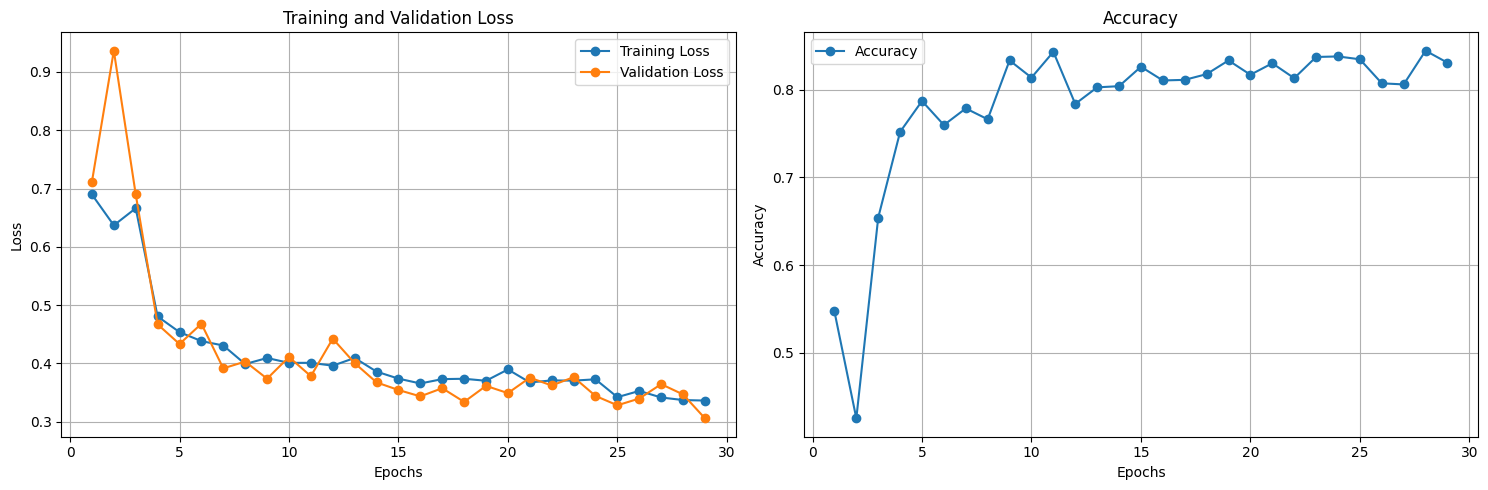

In [22]:
import matplotlib.pyplot as plt

# Assuming history is a dictionary that has 'train_loss' and 'val_loss' for each epoch
epoch = list(range(1, 30))  # Adjust this according to your actual number of epochs

# Extract training and validation losses as lists
train_losses = [history[i]["train_loss"].cpu().detach().numpy() for i in epoch]
val_losses = [history[j]["val_loss"] for j in epoch]
val_acc = [history[j]["val_acc"] for j in epoch]
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Training and Validation Loss
axs[0].plot(epoch, train_losses, label='Training Loss', marker='o')
axs[0].plot(epoch, val_losses, label='Validation Loss', marker='o')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plot Training and Validation Accuracy
axs[1].plot(epoch, val_acc, label='Accuracy', marker='o')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [23]:
test_loader=DataLoader(test_data,batch_size=256,shuffle=True)

In [24]:
def calculate_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy
accu = calculate_accuracy(model, test_loader, device)
print(f"Accuracy on the test dataset: {accu:.2f} %")

Accuracy on the test dataset: 83.99 %


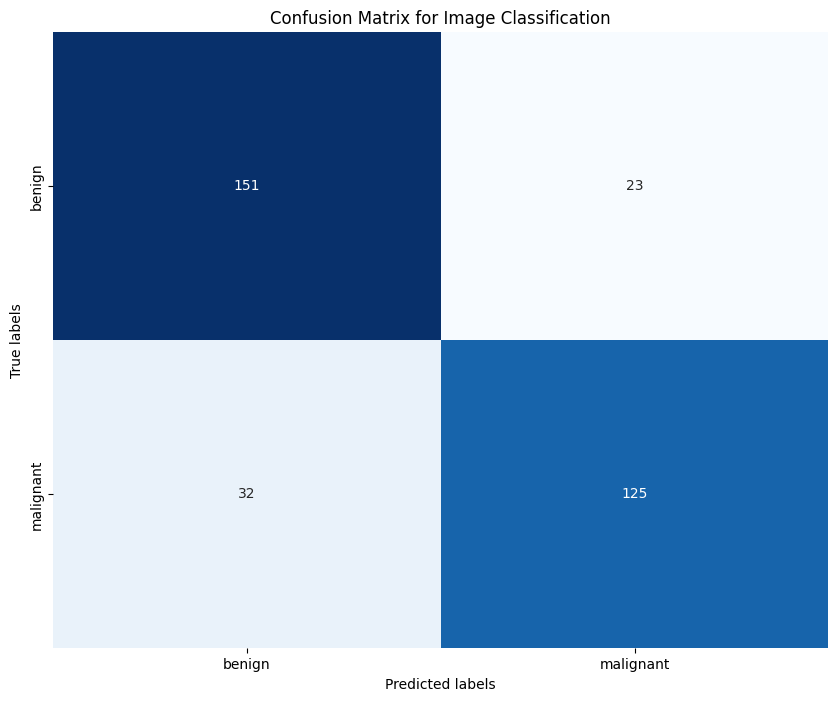

In [36]:
true_labels = []
predicted_labels = []
import seaborn as sns
with torch.no_grad():  # No need to calculate gradients for validation
    for images, labels in test_loader:
        images,labels=images.to(device),labels.to(device)
        outputs = model(images)  # Get model predictions
        _, preds = torch.max(outputs, 1)  # Get the predicted class indices

        true_labels.extend(labels.cpu().numpy())  # Append true labels
        predicted_labels.extend(preds.cpu().numpy())  # Append predicted labels

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Image Classification')
plt.show()

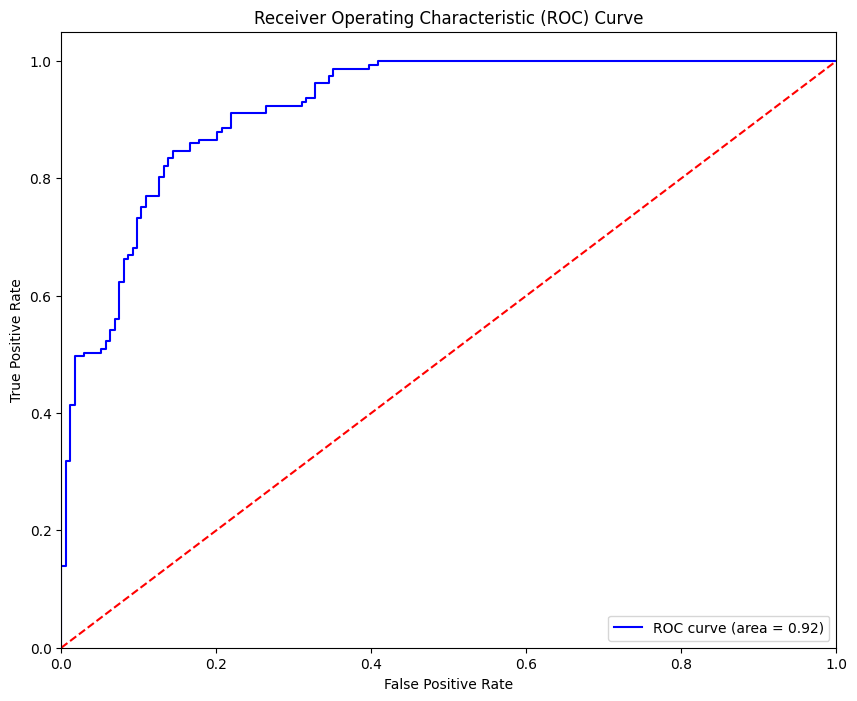

In [43]:
true_labels = []
predicted_probs = []
with torch.no_grad():  # No need to calculate gradients for validation
    for images, labels in test_loader:
        images,labels=images.to(device),labels.to(device)
        outputs = model(images)  # Get model predictions
        probs = torch.softmax(outputs, dim=1)  # Get probabilities (for multi-class)
        
        true_labels.extend(labels.cpu().numpy())  # Append true labels
        predicted_probs.extend(probs.cpu().numpy())  # Append predicted probabilities

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)
if predicted_probs.shape[1] == 2:  # Binary classification
    pos_probs = predicted_probs[:, 1]
else:  # Multi-class classification
    # Assuming class 1 is the positive class for ROC
    pos_probs = predicted_probs[:, 1]  # Adjust based on your positive class index

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels, pos_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
img ,label=dataset[1400]
print(img.shape)

torch.Size([3, 224, 224])


In [26]:
img=img.to(device)
img=img.unsqueeze(0)
logits=model(img)
_,pred=torch.max(logits,dim=1)

Actual Class: benign , Predicted class: benign


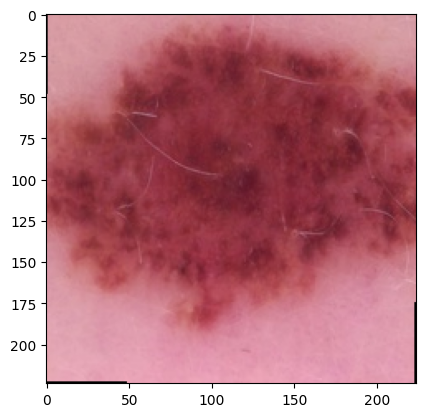

In [27]:
import matplotlib.pyplot as plt
print('Actual Class:',dataset.classes[label],',','Predicted class:',dataset.classes[pred])
plt.imshow(img.squeeze(0).cpu().permute(1,2,0))